# Load Data: Phishing Mail
link https://huggingface.co/datasets/zefang-liu/phishing-email-dataset


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [3]:
# Load data (source: https://huggingface.co/datasets/zefang-liu/phishing-email-dataset)


df = pd.read_csv("hf://datasets/zefang-liu/phishing-email-dataset/Phishing_Email.csv")

c:\Users\Alexis\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [5]:
df.shape

(18650, 3)

In [6]:
df.columns

Index(['Unnamed: 0', 'Email Text', 'Email Type'], dtype='object')

# Preprocesing data

In [7]:

# Check column names
print("\n📋 Columns:", df.columns.tolist())

# Check for missing values
print("\n🔍 Missing values:\n", df.isnull().sum())

# Check class distribution
print("\n⚖️ Class distribution:")
print(df['Email Type'].value_counts(normalize=True) * 100)

# Check for duplicates
print("\n🔍 Duplicated rows:", df.duplicated().sum())

# Check unique ID consistency
print("\n🔎 Unique Email No.:", df['Unnamed: 0'].nunique(), "/", len(df))


📋 Columns: ['Unnamed: 0', 'Email Text', 'Email Type']

🔍 Missing values:
 Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

⚖️ Class distribution:
Email Type
Safe Email        60.707775
Phishing Email    39.292225
Name: proportion, dtype: float64

🔍 Duplicated rows: 0

🔎 Unique Email No.: 18650 / 18650


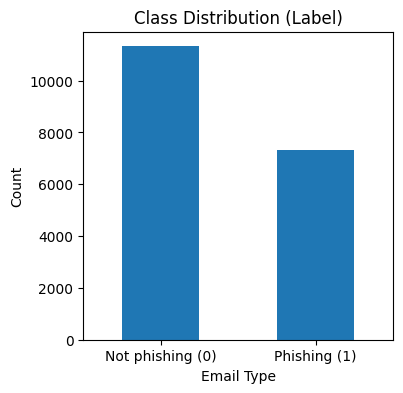

In [8]:
# Optional: visualize class distribution
plt.figure(figsize=(4,4))
df['Email Type'].value_counts().plot(kind='bar', title='Class Distribution (Label)')
plt.xticks(ticks=[0, 1], labels=['Not phishing (0)', 'Phishing (1)'], rotation=0)
plt.ylabel("Count")
plt.show()

In [9]:
# Check phishing email
df['Email Type'].value_counts()

Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64

In [10]:
# Remove rows where Email Text is missing
df_clean = df.dropna(subset=['Email Text'])


In [11]:
# Drop first column
df_clean = df.drop(columns= 'Unnamed: 0' , inplace=True,axis=1)

In [12]:
# Check for Placeholder Text (like 'empty')
placeholder_count = (df['Email Text'].str.lower() == 'empty').sum()
print(f"Rows with 'empty' as placeholder: {placeholder_count}")


Rows with 'empty' as placeholder: 533


In [13]:
empty_placeholder_rows = df[df['Email Text'].str.lower() == 'empty']
print(empty_placeholder_rows)

      Email Text      Email Type
54         empty  Phishing Email
106        empty      Safe Email
130        empty  Phishing Email
244        empty  Phishing Email
305        empty  Phishing Email
...          ...             ...
18607      empty      Safe Email
18626      empty      Safe Email
18637      empty  Phishing Email
18643      empty      Safe Email
18649      empty  Phishing Email

[533 rows x 2 columns]


In [14]:
# Drop empty values
df_clean = df[df['Email Text'].str.lower() != 'empty']

In [15]:
# Check for Truly Empty Strings
empty_string_count = (df['Email Text'] == '').sum()
print(f"Empty strings (''): {empty_string_count}")

Empty strings (''): 0


In [16]:
# Check for Strings with Only Whitespace
whitespace_count = df['Email Text'].str.strip().eq('').sum()
print(f"Whitespace-only strings: {whitespace_count}")

Whitespace-only strings: 3


In [32]:
# Remove rows where Email Text is empty or only whitespace (incl. \n, \t)
df_clean = df_clean[df_clean['Email Text'].str.strip().astype(bool)]

In [ ]:
# Binary numeric values
df['Email Type'] = df['Email Type'].map({'Safe Email' :1 ,'Phishing Email' : 0})

#  Define features (X) and target (y)
X = df_clean[['Email Text']]  #  text as features
y = df_clean['Email Type']   # target for stratification


In [18]:

# Perform 70-30 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


In [19]:
# Combine X and y for convenient inspection
train_df = X_train.copy()
train_df['Label'] = y_train

test_df = X_test.copy()
test_df['Label'] = y_test

print("\nFinal splits:")
print("Train:", train_df.shape)
print("Test:", test_df.shape)




Final splits:
Train: (12681, 2)
Test: (5436, 2)


In [26]:
y_train.head(5)

6066    Phishing Email
3030        Safe Email
8485    Phishing Email
8816    Phishing Email
5568        Safe Email
Name: Email Type, dtype: object

In [20]:
# Save files
train_df.to_csv("Data/train.csv", index=False)
test_df.to_csv("Data/test.csv", index=False)

# BERT Evaluation

In [21]:
import re
'''
# Function to clean email text
# This function normalizes whitespace, masks email addresses, URLs, and long numbers, and removes unwanted characters.
# BERT models typically require lowercased text, so we also convert the text to lowercase.
# This function is applied to each email text in the dataset.
# BERT models just analyse 512 tokens, so we don't need to worry about long texts.
'''
def clean_email_text(text):
    if isinstance(text, str):
        # Normalize whitespace characters
        text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
        text = re.sub(r'\s+', ' ', text)

        # Mask email addresses
        text = re.sub(r'\b[\w.-]+?@\w+?\.\w+?\b', ' [EMAIL] ', text)

        # Mask URLs
        text = re.sub(r'https?://\S+|www\.\S+', ' [URL] ', text)

        # Replace long numbers (IDs or phone numbers)
        text = re.sub(r'\d{5,}', ' [NUM] ', text)

        # Remove repeated punctuation like "!!!" or "??"
        text = re.sub(r'([!?.]){2,}', r'\1', text)

        # Remove unwanted characters but keep certain punctuations
        allowed_chars = r'[^\w\s\[\].,!?@-]'
        text = re.sub(allowed_chars, '', text)

        # Convert to lowercase and trim
        return text.strip().lower()

    return ""

# Apply the function
#df['clean_text'] = df['Email Text'].map(clean_email_text) for entire dataset
X_train['clean_text'] = X_train['Email Text'].map(clean_email_text)
X_test['clean_text'] = X_test['Email Text'].map(clean_email_text)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")
# Batched embedding function
def get_embeddings_batched(texts, batch_size=32):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]

        # Tokenize with padding and truncation
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Mean pool across tokens for each sequence
        last_hidden = outputs.last_hidden_state  # shape: [batch_size, seq_len, hidden_size]
        batch_embeddings = last_hidden.mean(dim=1).cpu().numpy()  # shape: [batch_size, hidden_size]

        all_embeddings.append(batch_embeddings)

    return np.vstack(all_embeddings)

# Apply to your DataFrame
train_texts = X_train['Email Text'].tolist()
test_texts = X_test['Email Text'].tolist()

train_embeddings = get_embeddings_batched(train_texts)
test_embeddings = get_embeddings_batched(test_texts)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

clf = RandomForestClassifier()
clf.fit(train_embeddings, y_train)

y_pred = clf.predict(test_embeddings)
print(classification_report(y_test, y_pred))

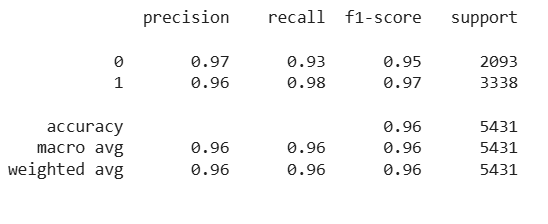

# Transformer all-MiniLM-L6-v2

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # fast + good quality
train_embeddings = model.encode(X_train['Email Text'].tolist(), show_progress_bar=True)
test_embeddings = model.encode(X_test['Email Text'].tolist(), show_progress_bar=True)

In [ ]:
clf = RandomForestClassifier()
clf.fit(train_embeddings, y_train)

y_pred = clf.predict(test_embeddings)
print(classification_report(y_test, y_pred))

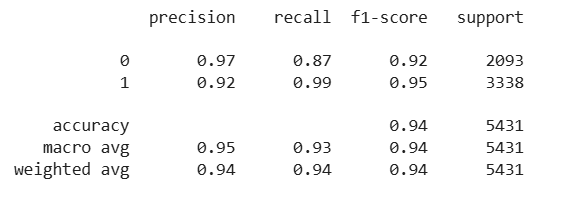

Classification Performance Comparison
Model F1-scores (by class)
| Model         | Class 0 (Safe) | Class 1 (Phishing) | Macro Avg | Weighted Avg |
| ------------- | -------------- | ------------------ | --------- | ------------ |
| **MiniLM-L6** | 0.92           | 0.95               | 0.94      | 0.94         |
| **BERT Base** | 0.95           | 0.97               | 0.96      | 0.96         |

Observations:
BERT slightly outperforms MiniLM-L6 across all metrics.

F1-score for phishing detection (Class 1) improved from 0.95 → 0.97

Macro and weighted averages are both higher for BERT, indicating more balanced performance.

Questions:


1.   I have 512 max lenght characters
2.   I have random forest, should I use other one?
